# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/omitted_data/')

In [3]:
Teusink_ant ='../../../models/Antimony/topologyA-reg1.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

9.995861419348e-16

In [4]:
pt_levels = [0, 0.1, 0.2, 0.3, 0.4,0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['knockout','0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

# Leaving out internal species concentrations

In [5]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [6]:
data0 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_0.csv')[fluxes+external+enzymes]
data01 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_0.1.csv')[fluxes+external+enzymes]
data02 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_0.2.csv')[fluxes+external+enzymes]
data03 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_0.3.csv')[fluxes+external+enzymes]
data04 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_0.4.csv')[fluxes+external+enzymes]
data05 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_0.5.csv')[fluxes+external+enzymes]

data15 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_1.5.csv')[fluxes+external+enzymes]
data3 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_3.csv')[fluxes+external+enzymes]
data5 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_5.csv')[fluxes+external+enzymes]
data7 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_7.csv')[fluxes+external+enzymes]
data100 = pd.read_csv('../../../data/interim/generated_data/topologyA-reg1/topologyA-reg1_10.csv')[fluxes+external+enzymes]

In [7]:
BMCA_obj0 = antemll.antemll(Teusink_ant, data0, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj01 = antemll.antemll(Teusink_ant, data01, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj02 = antemll.antemll(Teusink_ant, data02, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj03 = antemll.antemll(Teusink_ant, data03, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj04 = antemll.antemll(Teusink_ant, data04, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj05 = antemll.antemll(Teusink_ant, data05, '../../../models/sbml/topologyA_cobra.xml')

BMCA_obj15 = antemll.antemll(Teusink_ant, data15, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj3 = antemll.antemll(Teusink_ant, data3, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj5 = antemll.antemll(Teusink_ant, data5, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj7 = antemll.antemll(Teusink_ant, data7, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj100 = antemll.antemll(Teusink_ant, data100, '../../../models/sbml/topologyA_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


## Running ADVI

In [27]:
def run_BayesInf(BMCA_obj, n_samp=1):
    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in data100.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()
    
    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))

        # trace_prior = pm.sample_prior_predictive(samples=1000)
        
        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))

        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        # supposedly chi_t would be in the order listed in ss tellurium

        pm.Deterministic('chi_t', chi_t)

        e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T) # e_hat?
        y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BMCA_obj.yn.T) # yn?

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000))
        return samples
    else:
        return approx.sample(draws=1000)


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,932.1


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,692.3


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,543.1


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,435.7


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,344


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,263.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,194.5


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,603.5


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,371.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,893.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 6,854.9


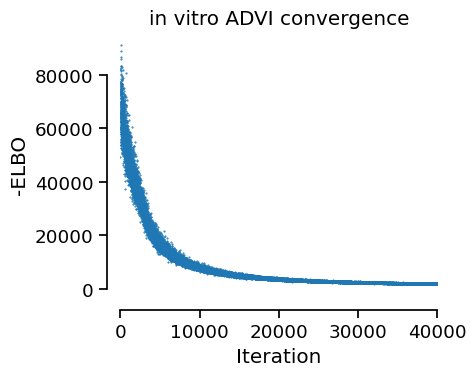

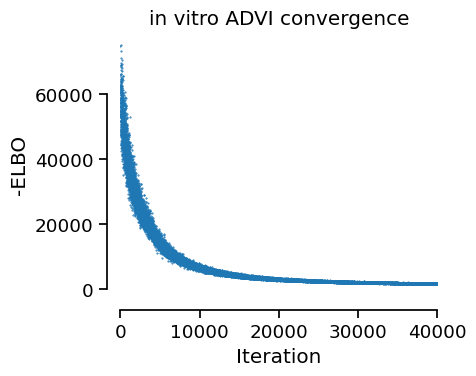

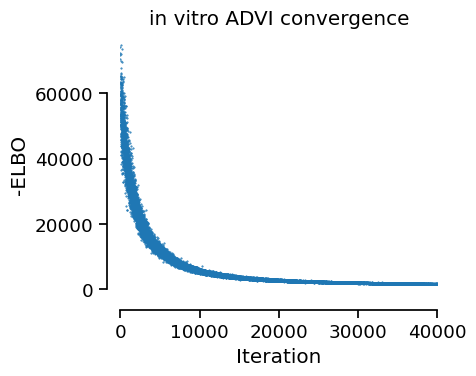

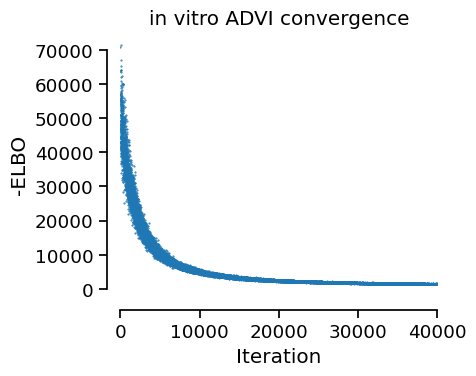

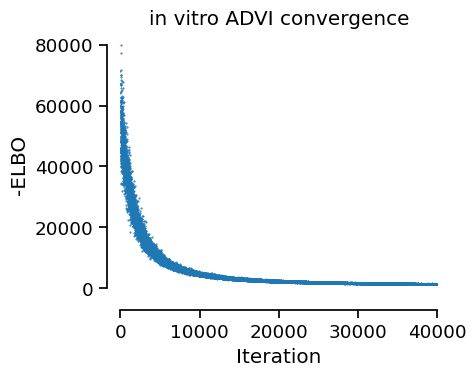

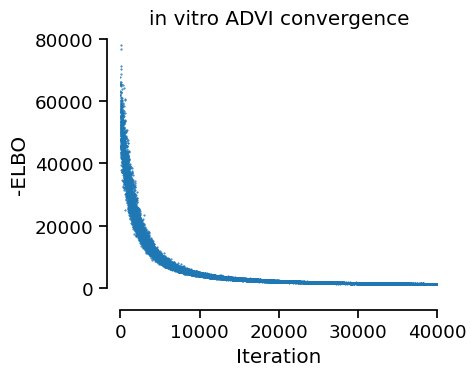

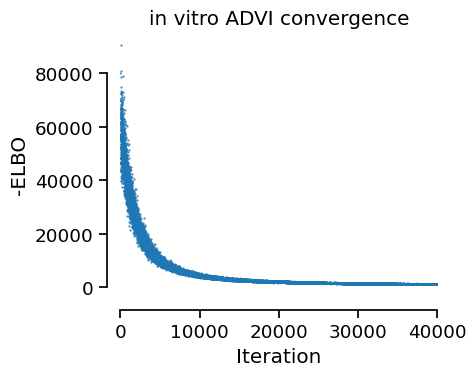

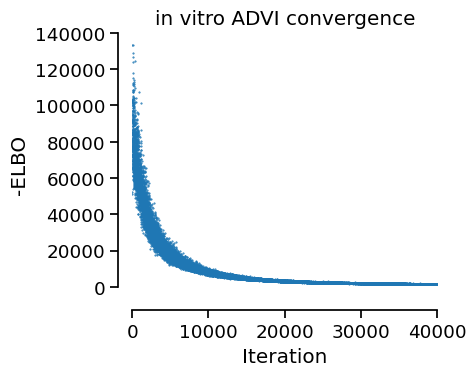

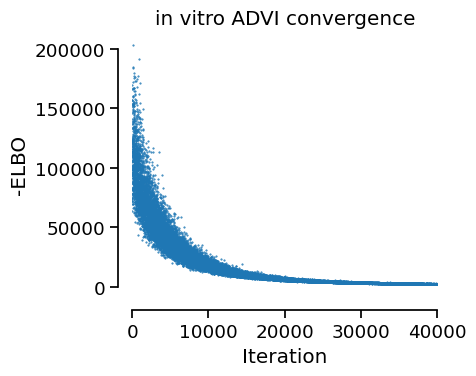

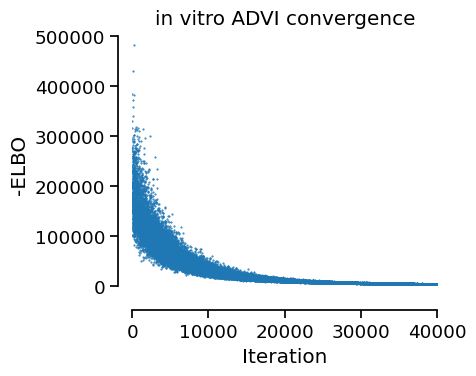

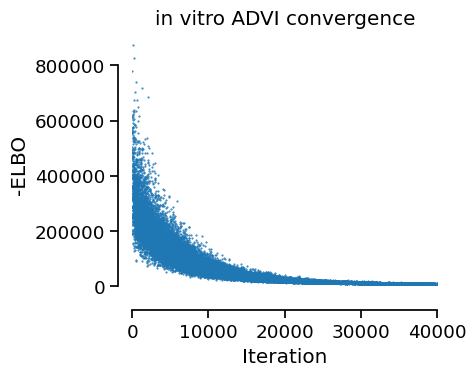

In [28]:
trace0 = run_BayesInf(BMCA_obj0, n_samp=3)
trace01 = run_BayesInf(BMCA_obj01, n_samp=3)
trace02 = run_BayesInf(BMCA_obj02, n_samp=3)
trace03 = run_BayesInf(BMCA_obj03, n_samp=3)
trace04 = run_BayesInf(BMCA_obj04, n_samp=3)
trace05 = run_BayesInf(BMCA_obj05, n_samp=3)

trace15 = run_BayesInf(BMCA_obj15, n_samp=3)
trace3 = run_BayesInf(BMCA_obj3, n_samp=3)
trace5 = run_BayesInf(BMCA_obj5, n_samp=3)
trace7 = run_BayesInf(BMCA_obj7, n_samp=3)
trace100 = run_BayesInf(BMCA_obj100, n_samp=3)

### saving trace data

In [29]:
with gzip.open("topologyA-reg1_omitIntMet_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace0":trace0,
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [8]:
# picklefolder = '../../../data/results/tracePickles/'
picklefolder = '../../../data/results/tracePickles-20240718/'
with gzip.open(picklefolder + 'topologyA-reg1_omitIntMet_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [9]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

In [10]:
med_Ex01_advi = util.get_az_mean(trace01)
med_Ex02_advi = util.get_az_mean(trace02)
med_Ex03_advi = util.get_az_mean(trace03)
med_Ex04_advi = util.get_az_mean(trace04)
med_Ex05_advi = util.get_az_mean(trace05)

med_Ex15_advi = util.get_az_mean(trace15)
med_Ex3_advi = util.get_az_mean(trace3)
med_Ex5_advi = util.get_az_mean(trace5)
med_Ex7_advi = util.get_az_mean(trace7)
med_Ex100_advi = util.get_az_mean(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [11]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                med_Ex01_advi, med_Ex02_advi, med_Ex03_advi, 
                               med_Ex04_advi, med_Ex05_advi, 
                               med_Ex15_advi, med_Ex3_advi, med_Ex5_advi, 
                               med_Ex7_advi, med_Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels[1:], 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-reg1_omitIntMet_elasticities.csv')

In [12]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels[1:]]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels[1:]]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels[1:]]

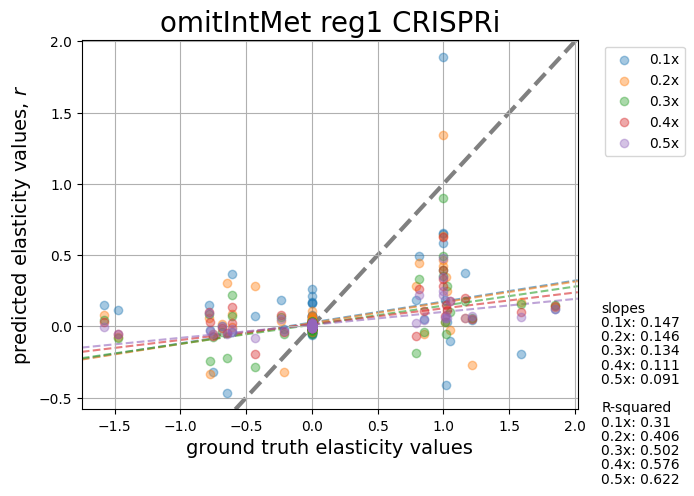

In [14]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('omitIntMet reg1 CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2.2
line_spacing = 0.1
slope_start = 0.1
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

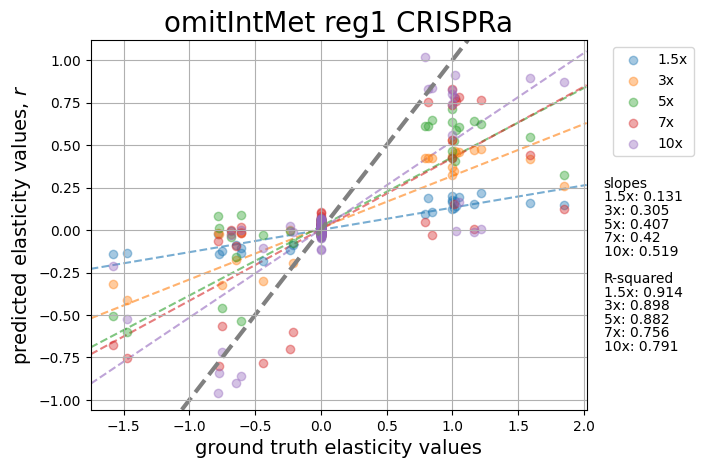

In [18]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('omitIntMet reg1 CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2.15
line_spacing = 0.08
slope_start = 0.25
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+6]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+6]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+6]), slope=e_slopes[i+6], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

In [13]:
# running ANOVA on differences btw gt and predicted
# elasticities_df = elasticities_df.sub(elasticities_df['gt'], axis=0)
stats.f_oneway(elasticities_df['0.1x'],
                elasticities_df['0.2x'],
                elasticities_df['0.3x'],
                elasticities_df['0.4x'],
                elasticities_df['0.5x'],
                elasticities_df['1.5x'],
                elasticities_df['3x'],
                elasticities_df['5x'],
                elasticities_df['7x'],
                elasticities_df['10x'])

F_onewayResult(statistic=0.6624635983613991, pvalue=0.7435224986659801)

In [13]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt      0.000000
0.1x    0.144566
0.2x    0.134761
0.3x    0.130191
0.4x    0.131894
0.5x    0.133431
1.5x    0.125746
3x      0.103494
5x      0.092894
7x      0.102545
10x     0.089501
dtype: float64

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

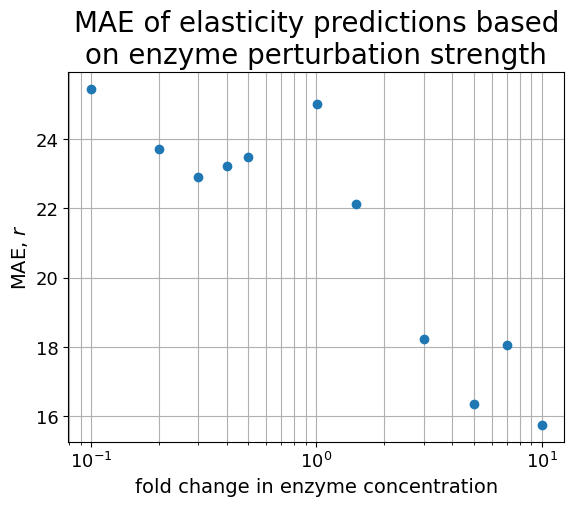

In [32]:
plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

In [ ]:
MAE.to_csv('topologyA-reg1_omitIntMet_MAE.csv')

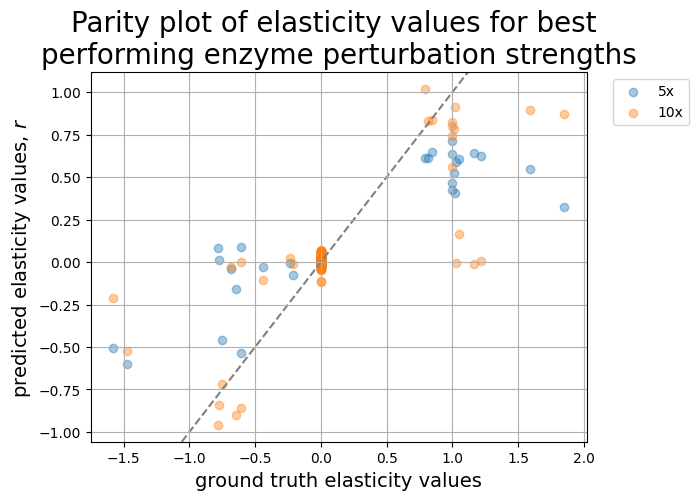

In [33]:
# best performers
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('Parity plot of elasticity values for best \nperforming enzyme perturbation strengths', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

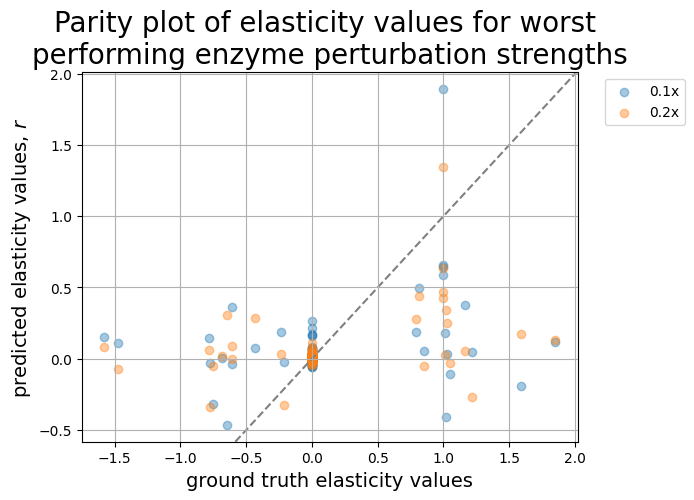

In [34]:
# worst performers
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x')
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('Parity plot of elasticity values for worst \nperforming enzyme perturbation strengths', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

## Calculating FCCs

In [36]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [37]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(3000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(3000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(3000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC


### Negative predictions

In [38]:
postFCC01 = estimate_CCs(BMCA_obj01, med_Ex01_advi.reshape((16,11)))
postFCC02 = estimate_CCs(BMCA_obj02, med_Ex02_advi.reshape((16,11)))
postFCC03 = estimate_CCs(BMCA_obj03, med_Ex03_advi.reshape((16,11)))
postFCC04 = estimate_CCs(BMCA_obj04, med_Ex04_advi.reshape((16,11)))

postFCC05 = estimate_CCs(BMCA_obj05, med_Ex05_advi.reshape((16,11)))
postFCC10 = estimate_CCs(BMCA_obj10, med_Ex10_advi.reshape((16,11)))
postFCC15 = estimate_CCs(BMCA_obj15, med_Ex15_advi.reshape((16,11)))
postFCC3 = estimate_CCs(BMCA_obj3, med_Ex3_advi.reshape((16,11)))
postFCC5 = estimate_CCs(BMCA_obj5, med_Ex5_advi.reshape((16,11)))
postFCC7 = estimate_CCs(BMCA_obj7, med_Ex7_advi.reshape((16,11)))
postFCC100 = estimate_CCs(BMCA_obj100, med_Ex100_advi.reshape((16,11)))

In [39]:
rxn_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x']

In [40]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [41]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vKIL,vLIM,vMIK,vNOV,vOSC,vPAP,vQUE,vROM,vSIE,vTAN,vUNI,vVIC,vWHI,vALP,vYAN,vZUL
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vKIL,0.1x,-11.190862,-1.423702,0.257780,2.635086,3.287604,0.154723,-2.297345,2.016524,1.466654,-1.521594,-0.047920,0.132233,-0.021451,5.655910,-0.054664,-0.048976
vLIM,0.1x,3.595819,-2.036527,-0.075243,-0.769152,-0.098505,0.030438,1.905527,-1.561349,-0.987339,1.103356,0.138872,-0.127096,0.020287,-2.272117,0.051698,0.081331
vMIK,0.1x,-14.505726,-2.054278,-0.687292,3.196566,4.766710,0.274263,-4.353150,3.747956,2.675149,-2.822814,-0.224250,0.263040,-0.042630,9.004474,-0.108636,-0.129383
vNOV,0.1x,-16.639103,-2.226450,0.362108,2.701551,5.253004,0.220478,-4.715304,4.076739,2.877667,-3.030069,-0.147072,0.281041,-0.045388,10.268778,-0.115666,-0.122313
vOSC,0.1x,3.595819,-0.036527,-0.075243,-0.769152,-2.098505,0.030438,1.905527,-1.561349,-0.987339,1.103356,0.138872,-0.127096,0.020287,-2.272117,0.051698,0.081331


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_24368\316825871.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

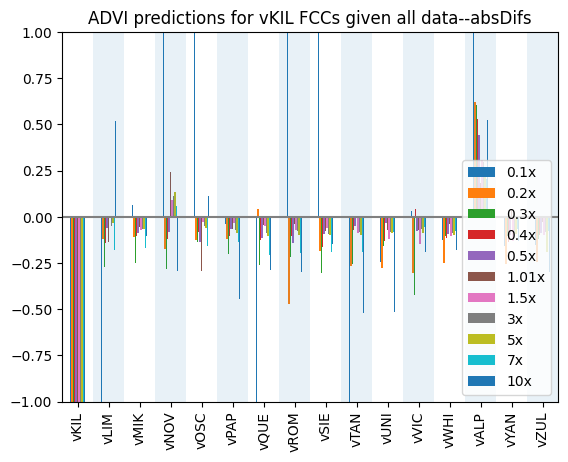

<Figure size 1600x1000 with 0 Axes>

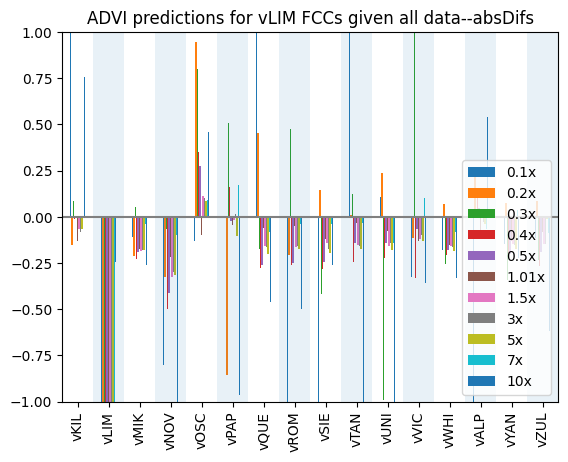

<Figure size 1600x1000 with 0 Axes>

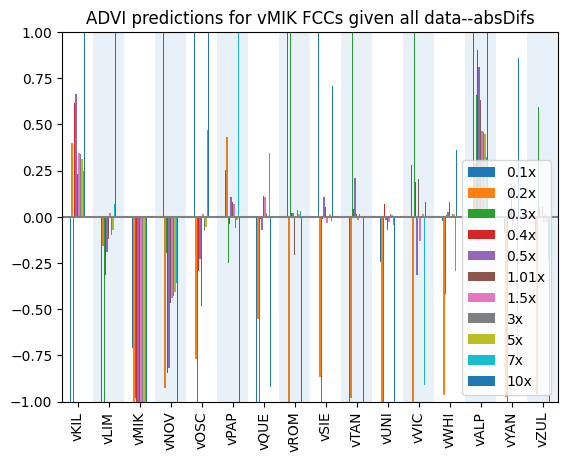

<Figure size 1600x1000 with 0 Axes>

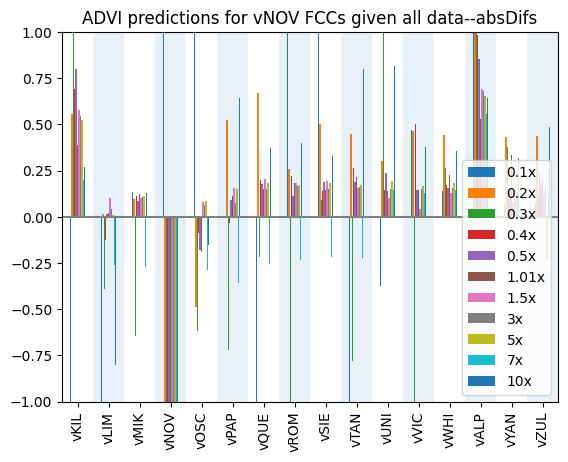

<Figure size 1600x1000 with 0 Axes>

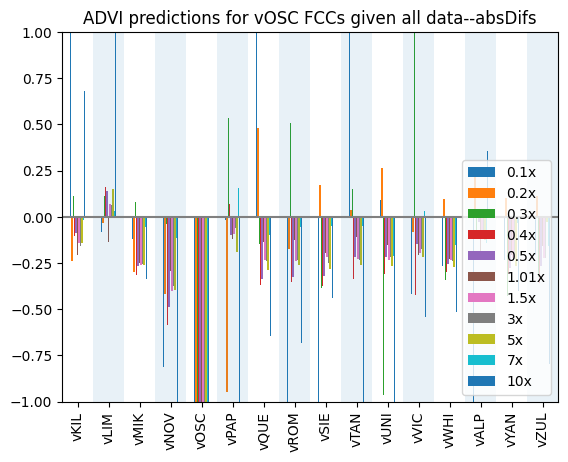

<Figure size 1600x1000 with 0 Axes>

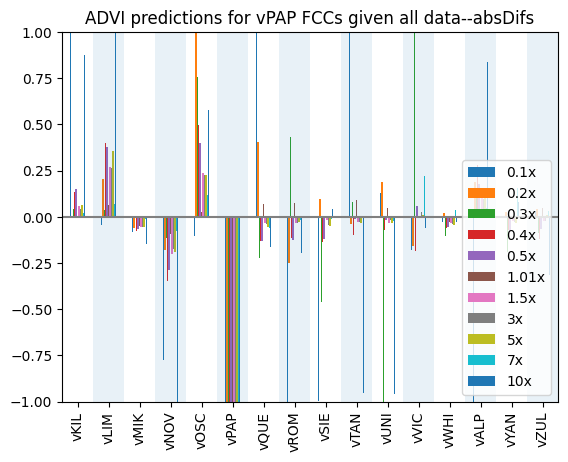

<Figure size 1600x1000 with 0 Axes>

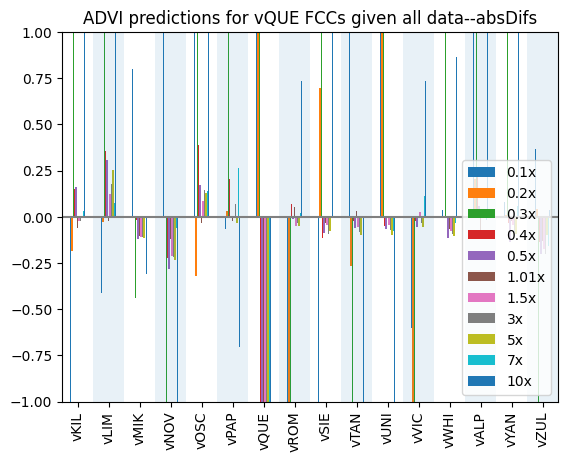

<Figure size 1600x1000 with 0 Axes>

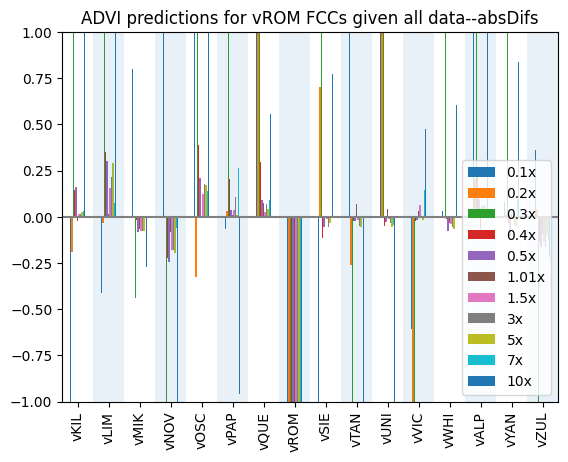

<Figure size 1600x1000 with 0 Axes>

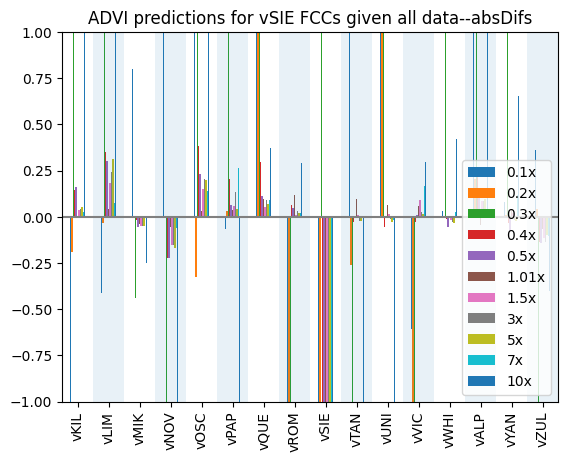

<Figure size 1600x1000 with 0 Axes>

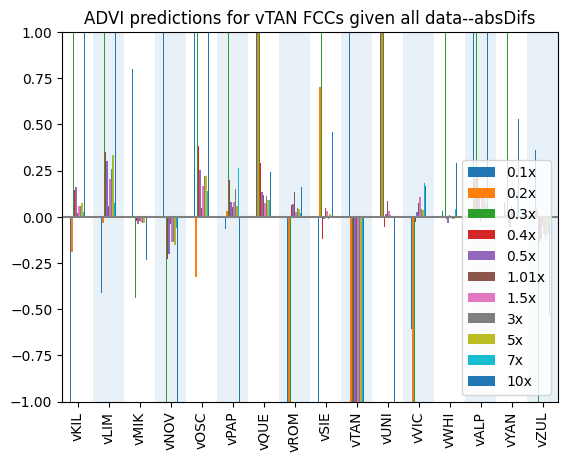

<Figure size 1600x1000 with 0 Axes>

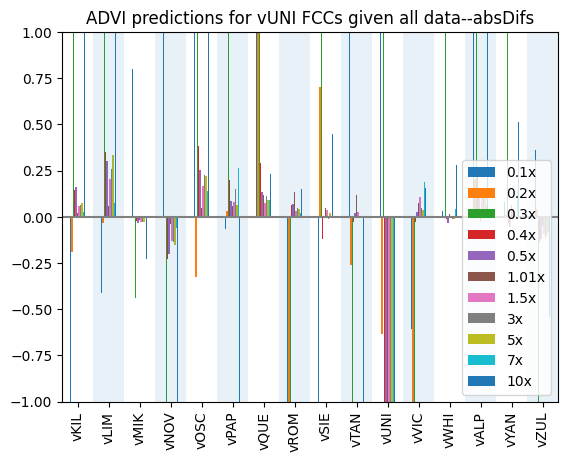

<Figure size 1600x1000 with 0 Axes>

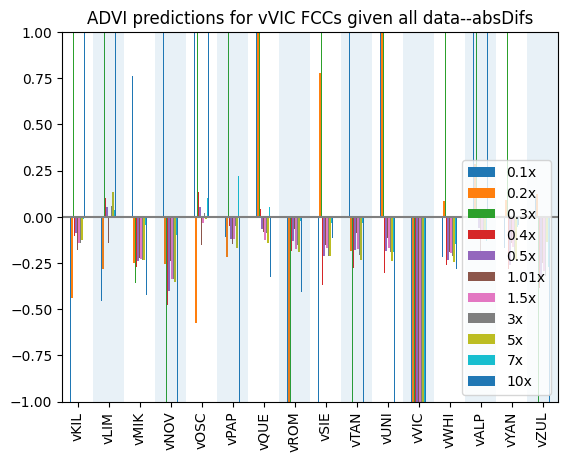

<Figure size 1600x1000 with 0 Axes>

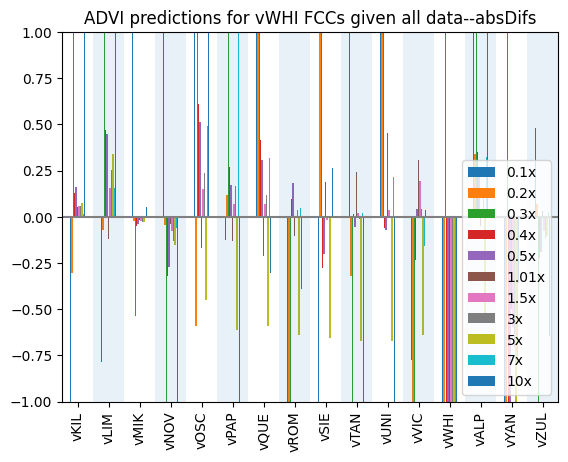

<Figure size 1600x1000 with 0 Axes>

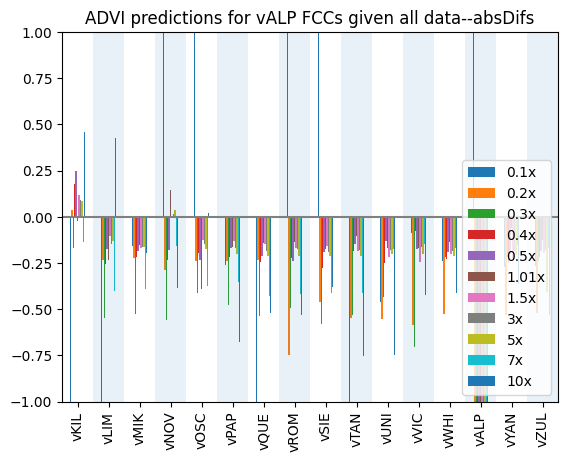

<Figure size 1600x1000 with 0 Axes>

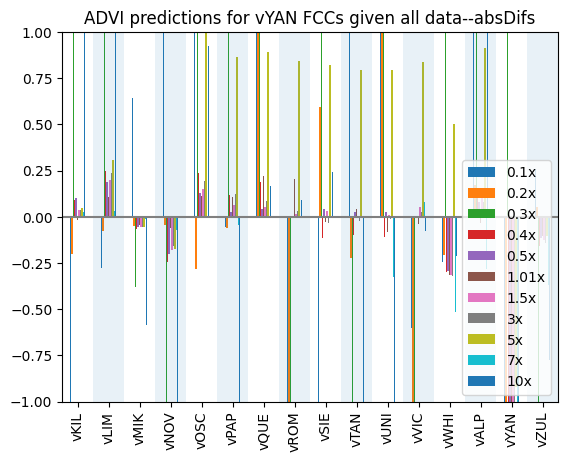

<Figure size 1600x1000 with 0 Axes>

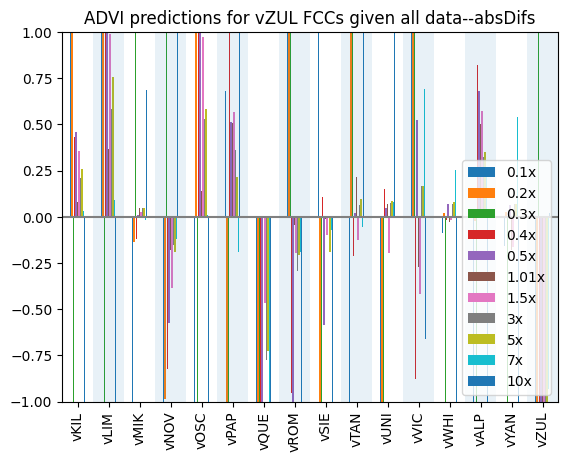

In [42]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    """
    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')
    """

In [43]:
plt.close("all")

## Evaluating FCC ranking

In [44]:
## ground truth FCC rankings

gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vYAN']

### via Spearman rank coefficients

In [45]:
def calculate_FCC_med_rankings(postFCC, reaction='vYAN'):
    postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    m1 = postFCC_med.index.values[:, None] == postFCC_med.columns.values
    postFCC = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=postFCC_med.columns, index=postFCC_med.index)
    postFCC_rankings= postFCC.rank(axis=1, ascending=False, na_option='keep')
    
    return postFCC_rankings.loc[reaction]
    

In [46]:
from scipy.stats import spearmanr

def bootstrap_spearman(x, y, num_bootstrap=1000, alpha=0.05):
    n = len(x)
    corr_list = []

    # Original Spearman correlation
    corr_original, p_value = spearmanr(x, y)

    for _ in range(num_bootstrap):
        # Generate bootstrap samples
        indices = np.random.randint(0, n, n)
        x_bootstrap = [x[i] for i in indices]
        y_bootstrap = [y[i] for i in indices]

        # Calculate Spearman correlation for the bootstrap sample
        corr, _ = spearmanr(x_bootstrap, y_bootstrap)
        corr_list.append(corr)

    # Convert to numpy array for convenience
    corr_list = np.array(corr_list)
    
    # Calculate the confidence intervals
    lower_bound = np.percentile(corr_list, (alpha/2) * 100)
    upper_bound = np.percentile(corr_list, (1 - alpha/2) * 100)
    
    return corr_original, p_value, lower_bound, upper_bound

In [47]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [48]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.1x,-0.121429,0.666401,-0.619656,0.421728
0.2x,0.053571,0.849610,-0.477546,0.573823
0.3x,0.010714,0.969770,-0.657066,0.599326
0.4x,0.685714,0.004772,0.210799,0.945561
0.5x,0.639286,0.010288,0.114297,0.945733
1.01x,0.292857,0.289472,-0.420290,0.770950
1.5x,0.871429,0.000023,0.557971,0.985379
3x,0.721429,0.002399,0.270260,0.934667
5x,0.835714,0.000104,0.447568,1.000000
7x,0.467857,0.078630,-0.157962,0.880440


In [49]:
spearman_df.to_csv('topologyA_reg1_omitIntMet_spr.csv')

In [ ]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

In [ ]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((-1, 1.05))

### evaluating top five rankings

In [ ]:
bump_df = pd.DataFrame(b_list, index=pt_levels).drop('vYAN', axis=1).drop(1.01)
bump_df

In [ ]:
n_lines = 14

# create colormap
cm = plt.cm.tab20(np.linspace(0, 1, n_lines))

# plot
ax = plt.subplot(111)
ax.set_prop_cycle('color', list(cm))
ax.plot(bump_df.index, bump_df.values, marker='o', markersize=10, label=list(bump_df.columns))

plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks(range(1,16))
gt_rank = a.drop('vYAN', axis=0)

plt.xlabel('enzyme perturbation strength')
plt.ylabel('predicted rank')
# plt.annotate(bump_df.index, bump_df.values[0], gt_rank)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [ ]:
ranked_b_list = [b.sort_values().reset_index().set_index('vYAN') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vYAN')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q

In [ ]:
q.to_csv('topologyA-reg1_omitIntMet_rankings.csv')